In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.utils import np_utils
import keras_tuner as kt
import warnings
warnings.filterwarnings("ignore")

Firstly we take a look at the image and the animal that we are going to analyse

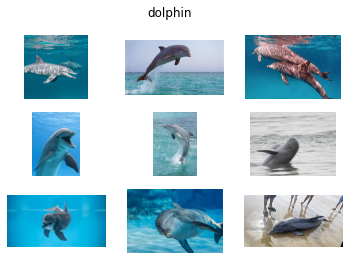

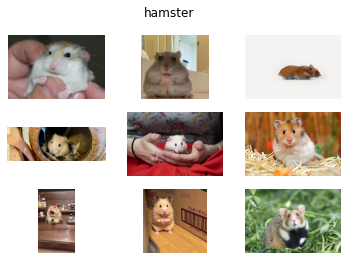

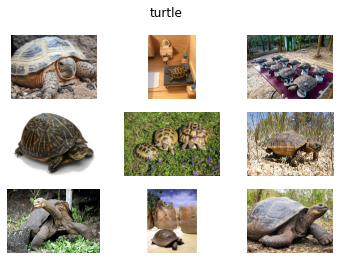

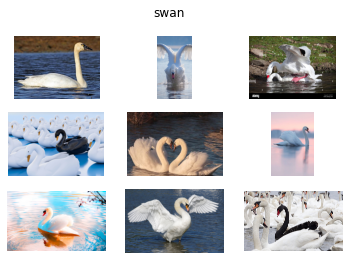

In [3]:
Path = r'C:/Users/Mattia/Desktop/DataScience/animals/'
animals = ['dolphin', 'hamster','turtle',"swan"]

for animal in animals:
    fig, _ = plt.subplots(3,3)
    fig.suptitle(animal)
    for k, v in enumerate(os.listdir(Path+animal)[:9]):
        img = plt.imread(Path+animal+'/'+v)
        plt.subplot(3, 3, k+1)
        plt.axis('off')
        plt.imshow(img)
    plt.show()

We study the height and the width of the image since in the next steps we are going to normalize them

In [4]:
height = []
width = []

for animal in animals:
    for files in os.listdir(Path+animal):
        height.append(plt.imread(Path+animal+'/'+ files).shape[0])
        width.append(plt.imread(Path+animal+'/'+ files).shape[1])
    print(animal, ' => height min : ', min(height), 'width min : ', min(width))
    print(animal, ' => height max : ', max(height), 'width max : ', max(width))
    height = []
    width = []

dolphin  => height min :  100 width min :  100
dolphin  => height max :  4000 width max :  5370
hamster  => height min :  100 width min :  100
hamster  => height max :  4912 width max :  7360
turtle  => height min :  100 width min :  100
turtle  => height max :  3434 width max :  5150
swan  => height min :  100 width min :  100
swan  => height max :  3560 width max :  5405


Here we ignore the aspect ratio and we normalize all the image to the same measure

In [5]:
feat = []
names = []
imagePaths = []
height = 32
width = 55
n_channels = 3

for k, animal in enumerate(animals):
    for f in os.listdir(Path+animal):
        imagePaths.append([Path+animal+'/'+f, k])

import random
random.shuffle(imagePaths)

for imagePath in imagePaths:
    image = cv2.imread(imagePath[0])
    image = cv2.resize(image, (width, height))
    feat.append(image)

    name = imagePath[1]
    names.append(name)

In [6]:
feat = np.array(feat, dtype="float") / 255.0
names = np.array(names)

We take a look that everything is still ok

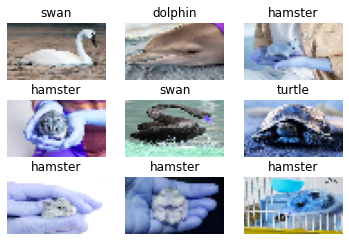

In [7]:
# Let's check everything is ok
plt.subplots(3,3)
for i in range(9):
    plt.subplot(3,3, i+1)
    plt.imshow(feat[i])
    plt.axis('off')
    plt.title(animals[names[i]])
plt.show()

Now we will divide the dataset in two part, 80% of it is going to be used as training while the other 20% is gonna be the test

In [8]:
(trainX, testX, trainY, testY) = train_test_split(feat, names, test_size=0.2, random_state=42, stratify=names)

In [11]:
print(trainX.shape)
print(testX.shape)
print(trainY.shape)
print(testY.shape)

(548, 32, 55, 3)
(138, 32, 55, 3)
(548,)
(138,)


Then we are gonna build our model using two Convolutions
Firstly we set the possibility of choice between different activation function and learning rate, then we add the function to our model.
In the end we train the model and apply the RandomSearch to find the best hyperparameters.

In [24]:
def build_model(hp):
    activation1 = hp.Choice("activation1", ["relu", "sigmoid", "selu","softmax"])
    lr = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model = Sequential()

    model.add(Conv2D(32, (2, 2), activation=activation1, input_shape=(height, width, n_channels)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, (2, 2), activation=activation1))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation=activation1))
    model.add(Dropout(0.5))
    model.add(Dense(4, activation="softmax"))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=lr),
             loss='categorical_crossentropy',
             metrics=['accuracy'])
    return model

def training(trainX, trainY, max_trials, executions_per_trial, overwrite, dir, project_name):
    # define the optimization algorithm
    tuner = kt.RandomSearch(build_model,
                            objective=kt.Objective("val_loss", direction ="min"),
                            max_trials=max_trials, # run model with different hyperparameter
                            executions_per_trial=executions_per_trial, # run model same hyperparameter
                            overwrite=overwrite,
                            directory=dir,
                            project_name=project_name
                            )

    history = tuner.search(trainX,
                            np_utils.to_categorical(trainY,4),
                            epochs=60,
                            validation_data=(testX, np_utils.to_categorical(testY,4)),
                            callbacks=[keras.callbacks.EarlyStopping(monitor="val_loss",
                                                                     patience=5,
                                                                     mode="min",
                                                                     restore_best_weights=True)])

    print(" ")
    print(" ")
    print("RESULT SUMMARY ##################")
    tuner.results_summary()
    return tuner

In [25]:
directory = Path

overwrite = True # set this parameter equal to false to read models already saved
trials = 25
ex_trails = 2
prj = "image_recog"

In [26]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tuner = training(trainX, trainY, trials, ex_trails, overwrite, directory, prj)
models = tuner.get_best_models(num_models=trials)

Trial 25 Complete [00h 02m 13s]
val_loss: 1.3837847113609314

Best val_loss So Far: 0.48694494366645813
Total elapsed time: 00h 24m 56s
 
 
RESULT SUMMARY ##################
Results summary
Results in C:/Users/Mattia/Desktop/DataScience/animals/image_recog
Showing 10 best trials
Trial summary
Hyperparameters:
activation1: relu
lr: 0.0010774292820526033
Score: 0.48694494366645813
Trial summary
Hyperparameters:
activation1: relu
lr: 0.0022556211284225536
Score: 0.49149878323078156
Trial summary
Hyperparameters:
activation1: relu
lr: 0.0009674781912297891
Score: 0.49951082468032837
Trial summary
Hyperparameters:
activation1: relu
lr: 0.00041818829630028666
Score: 0.5177744925022125
Trial summary
Hyperparameters:
activation1: relu
lr: 0.0002333905935392085
Score: 0.5318218171596527
Trial summary
Hyperparameters:
activation1: relu
lr: 0.0001154562309653233
Score: 0.5329271852970123
Trial summary
Hyperparameters:
activation1: selu
lr: 0.0001567123683813819
Score: 0.5390754044055939
Trial sum

In [27]:
models[0].summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 31, 54, 32)        416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 27, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 26, 32)        4128      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 7, 13, 32)        0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 7, 13, 32)         0         
                                                                 
 flatten (Flatten)           (None, 2912)              0

Now we apply the best model to the test set and we see that it has an accuracy equal to 86.96%

In [28]:
from sklearn.metrics import accuracy_score
best_model = tuner.get_best_models()[0]
predicted_classes = np.argmax(best_model.predict(testX), axis=-1)
accuracy_score(testY, predicted_classes)

5/5 [==============================] - 0s 11ms/step


0.8695652173913043

In the end we make some analysis and plot to see more specifically how this model works.
We can notice that the swan is the one with the lowest accuracy 76%, and that the worst combination is dolphin and swan since 9% of dolphins have been categorized as swan, and also in the other way 11% of the swans have been predicted as dolphin

5/5 [==============================] - 0s 10ms/step
[3 3 0 3 2 2 3 3 2 3 3 2 3 1 2 2 3 1 1 2 0 2 1 0 1 1 2 1 2 3 3 3 1 3 3 2 2
 0 3 2 3 0 3 1 1 2 1 0 0 0 0 3 1 3 3 2 1 2 2 0 1 3 1 3 1 0 3 3 1 0 0 0 2 0
 1 1 2 3 1 0 3 2 0 1 1 0 1 3 0 3 0 2 3 2 0 0 1 1 0 0 3 1 0 1 3 0 3 0 1 3 2
 0 2 1 1 2 0 2 3 1 3 1 0 3 1 3 0 2 2 2 1 0 2 2 1 1 1 2]


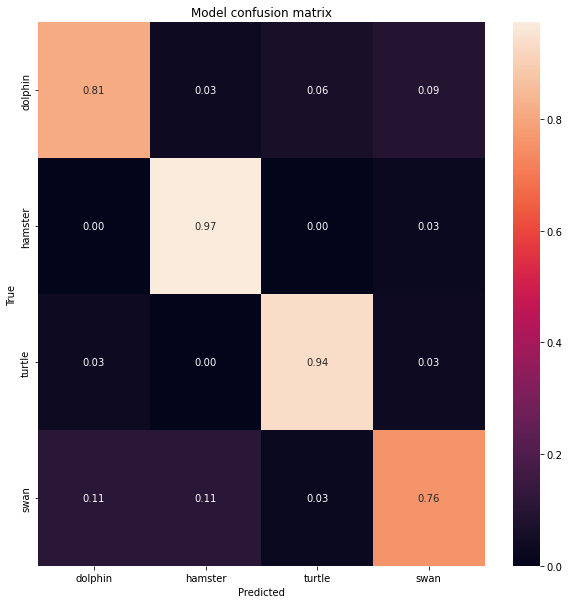

Total accuracy : 86.96%


In [29]:
from numpy import argmax
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns

best_model = tuner.get_best_models()[0]
predictions = np.argmax(best_model.predict(testX), axis=-1) # return to label
print(testY)
cm = confusion_matrix(testY, predictions)

cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
plt.title('Model confusion matrix')
sns.heatmap(cmn, annot=True, fmt='.2f', xticklabels=animals, yticklabels=animals)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


accuracy = accuracy_score(testY, predictions)
print("Total accuracy : %.2f%%" % (accuracy*100.0))

Here we see some funny predictions made by the model

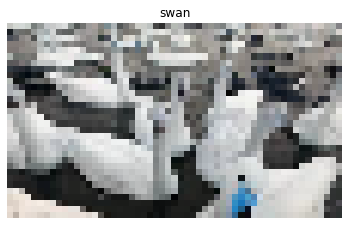

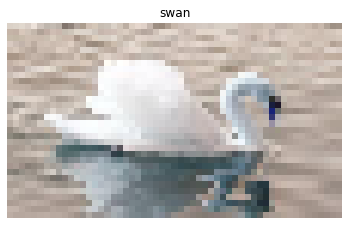

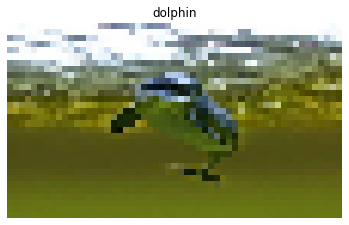

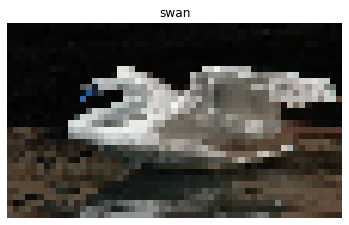

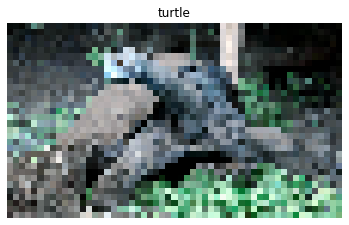

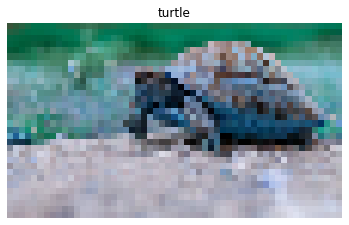

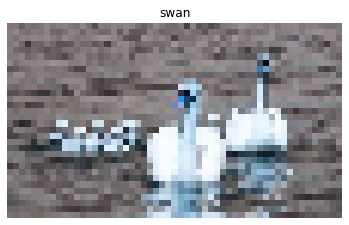

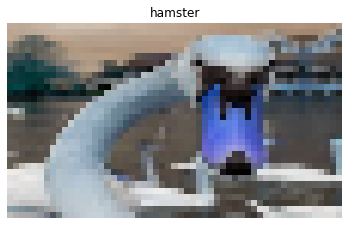

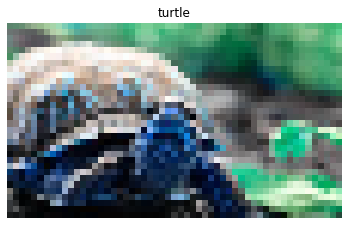

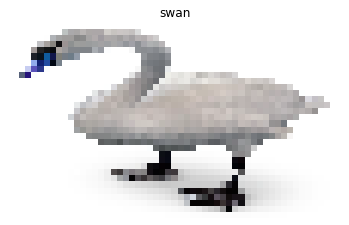

In [32]:
for i in range(10):
    plt.imshow(testX[i])
    plt.axis('off')
    plt.title(animals[predictions[i]])
    plt.show()